Seguir os passos descritos aqui https://www.kaggle.com/general/74235

ASSIGNMENT - Convolutional Neural Network 
Develop a CNN architecture to classify the Food-101 dataset available at https://www.kaggle.com/kmader/food41 
● Datasets provided (training and testing) 
○ Instructions on how to download the dataset and initial preparations are contained in the following notebook: 
https://colab.research.google.com/drive/19ORM_nArs8cTxCM5SBwn-Fb6I-dF2xDq?usp=sharing 
○ from the training set, create a validation set, if necessary 


Seguir os passos descritos aqui https://www.kaggle.com/general/74235

In [ ]:
! pip install -q kaggle
from google.colab import files 
files.upload() #aqui faz o upload do kaggle.json que voce gerou. Ver link acima.

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"osmarycamila","key":"b2a796620382795d497198c9dfc80b19"}'}

In [ ]:
! mkdir ~/.kaggle 
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d kmader/food41
!unzip food41.zip 

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 39% 2.08G/5.30G [00:16<00:26, 132MB/s] 
User cancelled operation
Archive:  food41.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of food41.zip or
        food41.zip.zip, and cannot find food41.zip.ZIP, period.


In [ ]:
import os
os.remove('food41.zip')

In [ ]:
images_per_class_train = 750
images_per_class_test = 250

n_classes = 10

In [ ]:
import os
with open('meta/meta/train.txt') as trainfile:
    trainlines = trainfile.readlines()
    trainlines = trainlines[0:images_per_class_train*n_classes]
    trainlines = [line.rstrip()+'.jpg' for line in trainlines]

with open('meta/meta/test.txt') as testfile:
    testlines = testfile.readlines()
    testlines = testlines[0:images_per_class_test*n_classes]

    testlines = [line.rstrip()+'.jpg' for line in testlines]

#!mkdir train/
#!mkdir test/

#create directories
with open('meta/meta/classes.txt') as classfile:
    classlines = classfile.readlines()
    classlines = classlines[0:n_classes]
    classlines = [line.rstrip() for line in classlines]

for class_ in classlines:
    try:
        os.makedirs('drive/MyDrive/Deep Learning/CNN/train/'+class_)
    except:
        pass
    try:
        os.makedirs('drive/MyDrive/Deep Learning/CNN/test/'+class_)
    except:
        pass

In [ ]:
import shutil

#move files to corresponding folder
for tl in trainlines:
    try:
        shutil.copy('images/'+tl, 'drive/MyDrive/DeepLearning/CNN/train/'+tl)
    except:
        print('error')
        pass
for tl in testlines:
    try:
        shutil.copy('images/'+tl, 'drive/MyDrive/DeepLearning/CNN/test/'+tl)
    except:
        print('error')
        pass

In [ ]:
import os.path
from os import path

path.exists('images')

True

Limpa o que nao vai ser usado

In [ ]:
#clean up
for class_ in classlines:
    try:
        os.rmdir('images/'+class_)
    except:
        pass
try:
    os.rmdir('images/')
except:
    pass

# Carregando os dados do Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [22]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.layers import AvgPool2D, GlobalAveragePooling2D, MaxPool2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras import backend as K
from tensorflow.keras.layers import ReLU, concatenate
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import argparse
import cv2
import sys

## Definindo os valores de entrada


In [23]:
NUMBER_CLASSES = 10
LEARNING_RATE = 0.1
BATCH_SIZE = 32
WIDTH = 224
NUM_EPOCHS = 50

images_per_class_train = 750
images_per_class_test = 250

In [24]:
datagen = ImageDataGenerator(rotation_range=30,
                             width_shift_range=0.2, height_shift_range=0.2,zoom_range=0.2,rescale = (1./128) - 1)

datagen_test = ImageDataGenerator(rescale = (1./128) - 1)

train_batches = datagen.flow_from_directory('drive/MyDrive/DeepLearning/CNN/train/', batch_size=BATCH_SIZE, class_mode = 'categorical', target_size=(WIDTH, WIDTH))
test_batches = datagen_test.flow_from_directory('drive/MyDrive/DeepLearning/CNN/test/', batch_size=BATCH_SIZE, class_mode = 'categorical', target_size=(WIDTH, WIDTH))

Found 7500 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


# Contruindo a CNN - DenseNet121


### Testei a DenseNet121 e tambem com diferentes arquiteturas ([2,3,12,8] and [6, 12, 24, 16]) porem os resultados foram bem ruins e o tempo de treino subiu muito, entao desconsiderei. 

In [25]:
# Construindo a rede

def buildNetworkDense (filters):
    '''Define a arquitetura da rede.'''

   #batch norm + relu + conv
    def bn_rl_conv(x,filters,kernel=1,strides=1):
        
        x = BatchNormalization()(x)
        x = ReLU()(x)
        x = Conv2D(filters, kernel, strides=strides,padding = 'same')(x)
        return x
    
    # Cocatenacao das features
    # Todas as camadas sao conectadas
    def dense_block(x, repetition):
        
        for _ in range(repetition):
            y = bn_rl_conv(x, 4*filters)
            y = bn_rl_conv(y, filters, 3)
            x = concatenate([y,x])
        return x
    
    # convolution and pooling
    # Camadas de transicao entre os blocos 
    def transition_layer(x):
        
        x = bn_rl_conv(x, K.int_shape(x)[-1] //2 )
        x = AvgPool2D(2, strides = 2, padding = 'same')(x)
        return x
    
     # Camada de entrada.
    input = Input ((WIDTH, WIDTH, 3))
    x = Conv2D(64, 7, strides = 2, padding = 'same')(input)
    x = MaxPool2D(3, strides = 2, padding = 'same')(x)
    
    # for repetition in [2,3,12,8]: 
    for repetition in [2,3,12,8]: # Configuracao para a arquitetura 121 [6, 12, 24, 16], 
        d = dense_block(x, repetition)
        x = transition_layer(d)
    x = GlobalAveragePooling2D()(d)
    output = Dense(NUMBER_CLASSES, activation = 'softmax')(x)
    
    model = Model(input, output)
    return model

#===============================================================================

# Contruindo a CNN 

In [26]:
model = Sequential()

model.add(layers.Conv2D(32, kernel_size=(5, 5),
                 strides=(2, 2), 
                 padding='valid',
                 input_shape=(224,224,3)))
model.add(layers.BatchNormalization(axis=3, scale=False))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), 
                 padding='valid',))
model.add(layers.BatchNormalization(axis=3, scale=False))
model.add(layers.Activation('relu'))

model.add(layers.Conv2D(64, kernel_size=(5, 5),
                 strides=(2, 2), 
                 padding='valid',
                ))
model.add(layers.BatchNormalization(axis=3, scale=False))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(5, 5),
                 strides=(2, 2), 
                 padding='valid',
                ))
model.add(layers.BatchNormalization(axis=3, scale=False))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.2))

model.add(Dense(NUMBER_CLASSES, activation='softmax'))
model.summary()


#adam = Adam(learning_rate=LEARNING_RATE) 
sgd = SGD(learning_rate=LEARNING_RATE)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 110, 110, 32)     96        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 110, 110, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 32)        25632     
                                                                 
 batch_normalization_1 (Batc  (None, 53, 53, 32)       96        
 hNormalization)                                                 
                                                                 
 activation_1 (Activation)   (None, 53, 53, 32)        0

In [17]:
hist = model.fit(
                train_batches,
                steps_per_epoch = images_per_class_train * NUMBER_CLASSES / BATCH_SIZE,
                epochs=NUM_EPOCHS,
                validation_data = test_batches,
                validation_steps= images_per_class_test * NUMBER_CLASSES / BATCH_SIZE)

Epoch 1/50
234/234 [==============================] - 361s 2s/step - loss: 2.3032 - accuracy: 0.2249 - val_loss: 2.6473 - val_accuracy: 0.1852
Epoch 2/50
234/234 [==============================] - 355s 2s/step - loss: 1.9517 - accuracy: 0.3084 - val_loss: 1.9350 - val_accuracy: 0.3100
Epoch 3/50
234/234 [==============================] - 358s 2s/step - loss: 1.8472 - accuracy: 0.3484 - val_loss: 1.5756 - val_accuracy: 0.4420
Epoch 4/50
234/234 [==============================] - 358s 2s/step - loss: 1.7726 - accuracy: 0.3757 - val_loss: 1.6714 - val_accuracy: 0.4120
Epoch 5/50
234/234 [==============================] - 354s 2s/step - loss: 1.7253 - accuracy: 0.3935 - val_loss: 1.7838 - val_accuracy: 0.3260
Epoch 6/50
234/234 [==============================] - 362s 2s/step - loss: 1.6802 - accuracy: 0.4023 - val_loss: 1.5138 - val_accuracy: 0.4620
Epoch 7/50
234/234 [==============================] - 362s 2s/step - loss: 1.6269 - accuracy: 0.4271 - val_loss: 1.3798 - val_accuracy: 0.5020

In [18]:
model.save('drive/MyDrive/DeepLearning/CNN/model')

INFO:tensorflow:Assets written to: drive/MyDrive/DeepLearning/CNN/model/assets


# Métricas do modelo

In [28]:
model = keras.models.load_model('drive/MyDrive/DeepLearning/CNN/model')

In [27]:
#definindo função para plotar history
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
plt.style.use('classic')

def plot_history(history,fold):

    fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,7))
    fig.suptitle('Fold {0}'.format(fold))

    
    #loss vs acc
    ax1.plot(history.history['accuracy'], label='training')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.legend(loc="lower right")
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
  
  
    ax2.plot(history.history['loss'], label='training')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.legend(loc="upper right")
 
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

Epoch 51/75
234/234 [==============================] - 4337s 19s/step - loss: 1.0788 - accuracy: 0.6256 - val_loss: 1.0873 - val_accuracy: 0.6156
Epoch 52/75
234/234 [==============================] - 266s 1s/step - loss: 1.0722 - accuracy: 0.6256 - val_loss: 1.1871 - val_accuracy: 0.6048
Epoch 53/75
234/234 [==============================] - 266s 1s/step - loss: 1.0621 - accuracy: 0.6301 - val_loss: 1.0158 - val_accuracy: 0.6416
Epoch 54/75
234/234 [==============================] - 264s 1s/step - loss: 1.0501 - accuracy: 0.6293 - val_loss: 1.0108 - val_accuracy: 0.6368
Epoch 55/75
234/234 [==============================] - 264s 1s/step - loss: 1.0634 - accuracy: 0.6347 - val_loss: 1.0826 - val_accuracy: 0.6172
Epoch 56/75
234/234 [==============================] - 263s 1s/step - loss: 1.0540 - accuracy: 0.6337 - val_loss: 1.3146 - val_accuracy: 0.5660
Epoch 57/75
234/234 [==============================] - 263s 1s/step - loss: 1.0482 - accuracy: 0.6343 - val_loss: 1.0142 - val_accurac

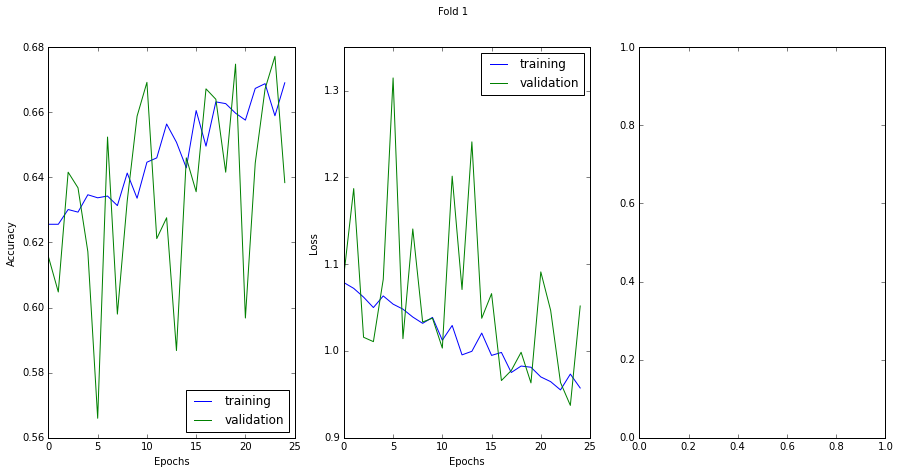

In [30]:
hist = model.fit(
                train_batches,
                steps_per_epoch = images_per_class_train * NUMBER_CLASSES / BATCH_SIZE,
                epochs=75, 
                initial_epoch=50,
                validation_data = test_batches,
                validation_steps= images_per_class_test * NUMBER_CLASSES / BATCH_SIZE,               
                )
model.save('drive/MyDrive/DeepLearning/CNN/model')

%matplotlib inline
plot_history(hist,1)

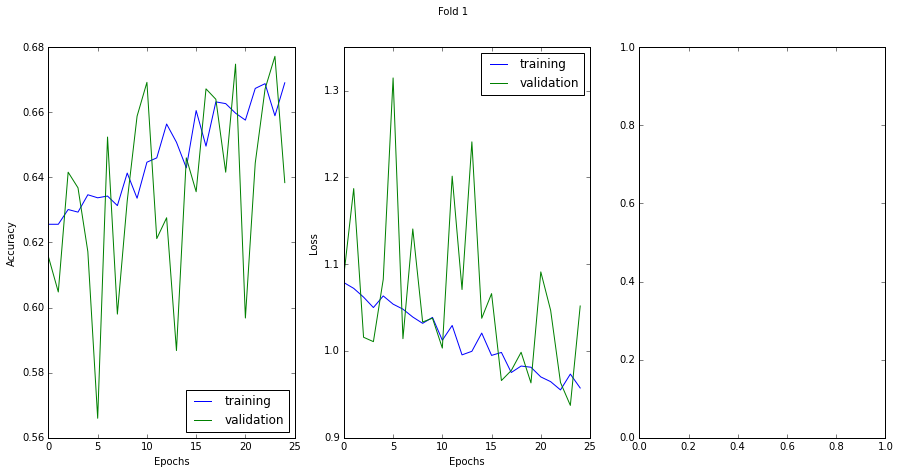

In [31]:
%matplotlib inline
plot_history(hist,1)